In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, report_fit
import random
import warnings
import matplotlib.pyplot as plt
import itertools

In [2]:
#Load and prepare data
path_tp = '../../../Data/'
dataTP_05mg = pd.read_csv(path_tp + 'Matthews2017/Digitized/PK/05mg_TP.csv')
dataTP_10mg_ = pd.read_csv(path_tp + 'Matthews2017/Digitized/PK/10mg_TP.csv')
dataTP_10mg_w1 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/10mg_TP_W1.csv')
dataTP_10mg_w3 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/10mg_TP_W3.csv')
dataTP_30mg_ = pd.read_csv(path_tp + 'Matthews2017/Digitized/PK/30mg_TP.csv')
dataTP_30mg_w1 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/30mg_TP_W1.csv')
dataTP_30mg_w3 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/30mg_TP_W3.csv')
dataTP_100mg_w1 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/100mg_TP_W1.csv')
dataTP_100mg_w3 = pd.read_csv(path_tp + 'Grobler2016/Digitized/PK/100mg_TP_W3.csv')
dataTP_1mg = pd.read_csv(path_tp + 'Matthews2017/Digitized/PK/1mg_TP.csv')
dataTP_2mg = pd.read_csv(path_tp + 'Matthews2017/Digitized/PK/2mg_TP.csv')

dataTP_05mg = dataTP_05mg.dropna(axis='columns')
dataTP_1mg = dataTP_1mg.dropna(axis='columns')
dataTP_2mg = dataTP_2mg.dropna(axis='columns')
dataTP_10mg_ = dataTP_10mg_.dropna(axis='columns')
dataTP_10mg_w1 = dataTP_10mg_w1.dropna(axis='columns')
dataTP_10mg_w3 = dataTP_10mg_w3.dropna(axis='columns')
dataTP_30mg_ = dataTP_30mg_.dropna(axis='columns')
dataTP_30mg_w1 = dataTP_30mg_w1.dropna(axis='columns')
dataTP_30mg_w3 = dataTP_30mg_w3.dropna(axis='columns')
dataTP_100mg_w1 = dataTP_100mg_w1.dropna(axis='columns')
dataTP_100mg_w3 = dataTP_100mg_w3.dropna(axis='columns')

dataTP_05mg.columns = ['time','conc']
dataTP_1mg.columns = ['time','conc']
dataTP_2mg.columns = ['time','conc']
dataTP_10mg_.columns = ['time','conc']
dataTP_10mg_w1.columns = ['time','conc']
dataTP_10mg_w3.columns = ['time','conc']
dataTP_30mg_.columns = ['time','conc']
dataTP_30mg_w1.columns = ['time','conc']
dataTP_30mg_w3.columns = ['time','conc']
dataTP_100mg_w1.columns = ['time','conc']
dataTP_100mg_w3.columns = ['time','conc']

dataTP_10mg = pd.concat([dataTP_10mg_, dataTP_10mg_w1, dataTP_10mg_w3]).sort_values(by=['time']).reset_index(drop=True)
dataTP_30mg = pd.concat([dataTP_30mg_, dataTP_30mg_w1, dataTP_30mg_w3]).sort_values(by=['time']).reset_index(drop=True)
dataTP_100mg = pd.concat([dataTP_100mg_w1, dataTP_100mg_w3]).sort_values(by=['time']).reset_index(drop=True)

dataTP_10mg.time.iloc[0] = abs(dataTP_10mg.time.iloc[0])

datalist_TP = [dataTP_10mg, dataTP_30mg, dataTP_100mg, dataTP_2mg, dataTP_1mg, dataTP_05mg]
data_TP = pd.concat([dataTP_10mg, dataTP_30mg, dataTP_100mg, dataTP_2mg, dataTP_1mg, dataTP_05mg]) #assembled data

# convert to unit nM
data_TP.conc = 6 - np.log10(180) + data_TP.conc.tolist()
for n in range(len(datalist_TP)): #to nM    
    datalist_TP[n].conc = 6 - np.log10(180) + datalist_TP[n].conc.tolist()

In [3]:
#Compartment Model linear PK
def model_TP_linear(t, z, params):
    #parameters to estimate
    k13 = params['k13'].value
    k30 = params['k30'].value
    Z0 = z[0]; Z1 = z[1]; Z2 = z[2]; Z3 = z[3]
    dZ0 = -ka*Z0
    dZ1 = (ka/Vc)*Z0 - k10*Z1 - k12*Z1 + k21*Z2
    dZ2 = k12*Z1 - k21*Z2
    dZ3 = k13*Z1 - k30*Z3
    d = [dZ0,dZ1,dZ2,dZ3]
    return d

def solve_ode(z, data_mat, params):
    '''
    Solve the ODE-system for
    z = initial state of the system
    data_mat = assembled data set
    params = parameters to estimate
    
    return list of drug concentrations from intracellular compartment (Z3)
    '''
    ind = data_mat.index.tolist() #get indices
    offset = 0 #each data set is continuously numbered
    logZ3 = []
    for j in range(len(z)):
        i = 0 
        while (ind[i+offset] == i): #while index euqlas offset
            i += 1
            if i+offset > len(ind)-1: #break if end of list is reached
                break
        offset += i #add current index to offset
        t_obs = data_mat.time[offset-i:offset].tolist()
        res = solve_ivp(model_TP_linear, (tstart,tfinal[j]), z[j], t_eval=t_obs,args=(params,))
        logZ3.append(np.log10(res.y[3])) #intracellular compartment
    return list(itertools.chain.from_iterable(logZ3))

def solve_ode_simple(z, t_obs, params): #solve ode for a single data set
    res = solve_ivp(model_TP_linear, (tstart,tfinal), z, t_eval=t_obs,args=(params,))
    return res

def residual_TP(params, z, data_mat):
    logZ3 = solve_ode(z, data_mat, params)
    cl = data_TP.conc.tolist()
    return np.power(np.subtract(logZ3, cl),2)

def new_params():
    #sample parameters to be optimized
    global parameters
    v13 = random.uniform(0,100)
    v30 = random.uniform(0,1)    
    parameters = Parameters()
    parameters.add('k13', value = v13, min = 0, max = 100)
    parameters.add('k30', value = v30, min = 0, max = 1)
   

In [4]:
#Global parameters
dose = 3410 #nM

tstart = 0 #initial and final time of the system
tfinal = []
for i in range(len(datalist_TP)):
    t_obs = datalist_TP[i]['time'].tolist()
    tfinal.append(t_obs[-1])

#initial states of the system    
z0 = [[10*dose,0,0,0],[30*dose,0,0,0], [100*dose,0,0,0],[2*dose,0,0,0],[dose,0,0,0],[0.5*dose,0,0,0]] 

#Estimated PK plasma parameters
ka = 45.4382
k10 =  0.2355
k12 =  0.1750
k21 =  0.0259
Vc =  162.69

In [7]:
warnings.filterwarnings('ignore')    

threshold = -100 #user-defined threshold
count = 0; maxcount = 10 #initial and maximal number of iterations
rssList = []; 
k13List = []; k30List = []; aicList = []

while count < maxcount:
    new_params() #sample parameters
    success = True
    try:
        result = minimize(residual_TP, parameters, args=(z0,data_TP), method = 'leastsq') #Levenberg-Marquardt algorithm
        #report_fit(result)
        if result.aic < threshold: 
            rss = np.sum(residual_TP(result.params,z0,data_TP))
            aicList.append(result.aic)
            rssList.append(rss)
            k13List.append(result.params['k13'].value)
            k30List.append(result.params['k30'].value)
        else: 
            success = False
            print('AIC too large')
            new_params()
    except:
        print('an unexpected error occurred!')
        success = False
        new_params()
       
    if success:
        count += 1
        print(); print('run ',count,' finished') 


run  1  finished

run  2  finished

run  3  finished

run  4  finished

run  5  finished

run  6  finished

run  7  finished

run  8  finished

run  9  finished

run  10  finished


In [8]:
#Evaluation
dfResult = pd.DataFrame(list(zip(aicList,rssList,k13List,k30List)), 
                        columns =['AIC', 'RSS', 'k13', 'k30']) 
print(); print(dfResult)

#dfResult.to_excel('pk_linear_it50_bound500.xlsx')   #store result


          AIC       RSS        k13       k30
0 -334.072029  7.053504  58.810911  0.011039
1 -334.072029  7.052634  58.806347  0.011039
2 -334.072029  7.052649  58.806430  0.011039
3 -334.072030  7.053517  58.811838  0.011040
4 -334.072029  7.053730  58.812764  0.011039
5 -334.072029  7.052497  58.805452  0.011039
6 -334.072030  7.052948  58.808553  0.011040
7 -334.072029  7.053283  58.810952  0.011040
8 -334.072029  7.052665  58.806546  0.011039
9 -334.072029  7.052652  58.805815  0.011039


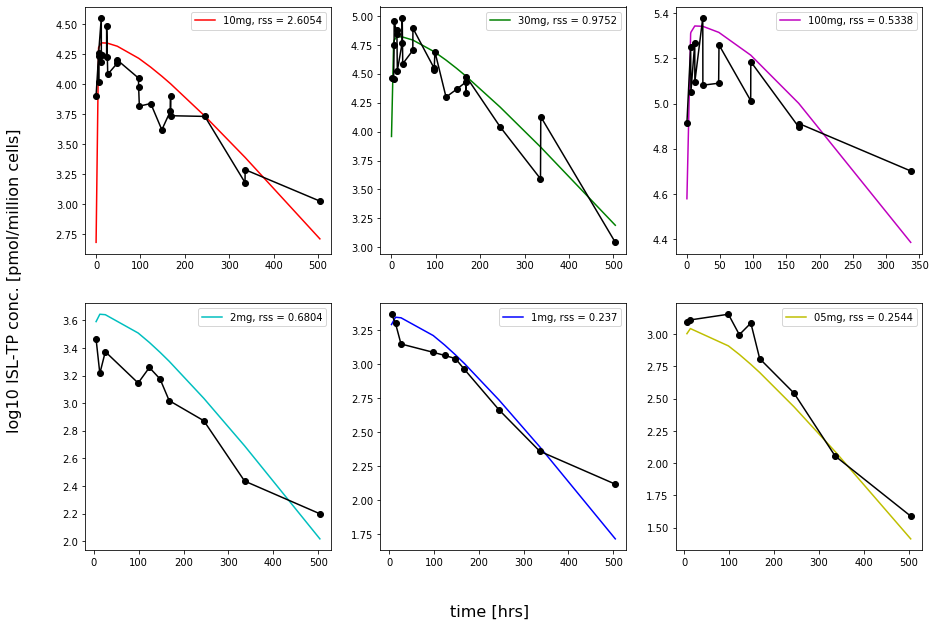

In [9]:
#plot result
tstart=0

#Estimated parameters
v13 = 44.2403
v30 = 0.0098

parameters = Parameters()
parameters.add('k13', value=v13, vary=False)
parameters.add('k30', value=v30, vary=False)

fig, axs = plt.subplots(2,3, figsize=(15, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()

l = ['10mg', '30mg', '100mg', '2mg', '1mg', '05mg'] #label
c = ['r-', 'g-', 'm-', 'c-', 'b-', 'y-'] #color and line style

i=0
for d in datalist_TP:
    tfinal= max(d.time.tolist())
    res = solve_ode_simple(z0[i], d.time.tolist(), parameters)
    log_Z3 = np.log10(res.y[3])
    rss = np.sum(np.power(np.subtract(log_Z3, d.conc.tolist()),2))
    axs[i].plot(d.time.tolist(), log_Z3, c[i], label=l[i]+', rss = '+str(round(rss,4)))
    axs[i].plot(d.time.tolist(), d.conc.tolist(), 'ko-')
    axs[i].legend()
    i+=1

fig.text(0.5, 0.04, 'time [hrs]', ha='center', va='center', fontsize=16);
fig.text(0.06, 0.5, 'log10 ISL-TP conc. [pmol/million cells]', ha='center', va='center', rotation='vertical', fontsize=16);

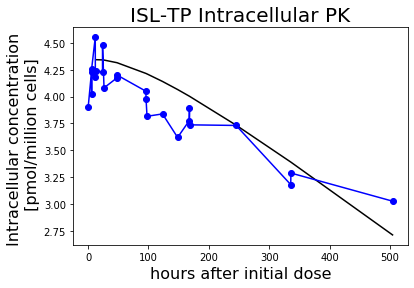

In [10]:
#plot single data
tstart=0

v13 = 44.2403
v30 = 0.0098

parameters = Parameters()
parameters.add('k13', value=v13, vary=False)
parameters.add('k30', value=v30, vary=False)

i=0
res = solve_ode_simple(z0[i], datalist_TP[i].time.tolist(), parameters)
log_Z4 = np.log10(res.y[3])

plt.plot(datalist_TP[i][6:].time.tolist(), log_Z4[6:], 'k-')
plt.plot(datalist_TP[i].time.tolist(), datalist_TP[i].conc.tolist(), 'bo-')
plt.title('ISL-TP Intracellular PK', fontsize=20)
plt.xlabel('hours after initial dose', fontsize=16)
plt.ylabel('Intracellular concentration \n [pmol/million cells]',fontsize=16)
plt.show()